In [32]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import optimize
from matplotlib.ticker import FormatStrFormatter

In [33]:
sdir = '/Users/thepoetoftwilight/Documents/SOFIA_FIFI_Cycle-8/Data/NGC_2366_sw_1/'

savedir = '/Users/thepoetoftwilight/Documents/SOFIA_FIFI_Cycle-8/Data/NGC_2366_sw_1/Spectra/'

if not os.path.exists(savedir):
    os.makedirs(savedir)

fits_name = 'NGC_2366_sw_1.fits'

In [34]:
hdulist = fits.open(sdir + fits_name)

hdulist.info()

Filename: /Users/thepoetoftwilight/Documents/SOFIA_FIFI_Cycle-8/Data/NGC_2366_sw_1/NGC_2366_sw_1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     329   ()      
  1  FLUX          1 ImageHDU        28   (33, 35, 58)   float64   
  2  ERROR         1 ImageHDU        28   (33, 35, 58)   float64   
  3  UNCORRECTED_FLUX    1 ImageHDU        28   (33, 35, 58)   float64   
  4  UNCORRECTED_ERROR    1 ImageHDU        28   (33, 35, 58)   float64   
  5  WAVELENGTH    1 ImageHDU         7   (58,)   float64   
  6  X             1 ImageHDU         7   (33,)   float64   
  7  Y             1 ImageHDU         7   (35,)   float64   
  8  TRANSMISSION    1 ImageHDU         7   (58,)   float64   
  9  RESPONSE      1 ImageHDU         7   (58,)   float64   
 10  EXPOSURE_MAP    1 ImageHDU        28   (33, 35, 58)   int16   
 11  UNSMOOTHED_TRANSMISSION    1 ImageHDU         8   (1675, 2)   float64   


In [35]:
hdulist[1].header

XTENSION= 'IMAGE   '           /extension type                                  
BITPIX  =                  -64 /bits per data value                             
NAXIS   =                    3 /number of axes                                  
NAXIS1  =                   33 /                                                
NAXIS2  =                   35 /                                                
NAXIS3  =                   58 /                                                
PCOUNT  =                    0 /                                                
GCOUNT  =                    1 /                                                
EXTNAME = 'FLUX    '           /                                                
DATE-OBS= '2019-05-14T07:46:57' / Observation date                              
BUNIT   = 'Jy/pixel'           / Data units                                     
EQUINOX =              2000.00 / Coordinate equinox                             
CTYPE1  = 'RA---TAN'        

In [36]:
wavelengths = hdulist[5].data

x_coords = hdulist[6].data
x_min = x_coords[0]
x_max = x_coords[len(x_coords)-1]

y_coords = hdulist[7].data
y_min = y_coords[0]
y_max = y_coords[len(y_coords)-1]

print(wavelengths)

wav_diff = []

for i in range(0, len(wavelengths)-1):
    wav_diff.append(wavelengths[i+1]-wavelengths[i])
  
wav_diff = np.average(wav_diff)

print(wav_diff)

[51.6259798  51.63317882 51.64037784 51.64757686 51.65477588 51.66197489
 51.66917391 51.67637293 51.68357195 51.69077097 51.69796999 51.70516901
 51.71236803 51.71956705 51.72676606 51.73396508 51.7411641  51.74836312
 51.75556214 51.76276116 51.76996018 51.7771592  51.78435822 51.79155724
 51.79875625 51.80595527 51.81315429 51.82035331 51.82755233 51.83475135
 51.84195037 51.84914939 51.85634841 51.86354743 51.87074644 51.87794546
 51.88514448 51.8923435  51.89954252 51.90674154 51.91394056 51.92113958
 51.9283386  51.93553762 51.94273663 51.94993565 51.95713467 51.96433369
 51.97153271 51.97873173 51.98593075 51.99312977 52.00032879 52.00752781
 52.01472682 52.02192584 52.02912486 52.03632388]
0.007199018980237158


In [37]:
# wavelength is the first dimension
# y is the second dimension
# x is the third dimension

fluxmaps = hdulist[1].data

fluxmaps_min = np.nanmin(fluxmaps.flatten())
fluxmaps_max = np.nanmax(fluxmaps.flatten())

print(fluxmaps.shape)

(58, 35, 33)


In [38]:
def sum_spaxel(fluxmap, k_x, k_y):
    
    n_x = len(fluxmap[0])
    n_y = len(fluxmap)
    
    id_x = np.arange(np.floor((n_x-k_x)/2), np.floor((n_x-k_x)/2) + k_x, 1)
    id_x = id_x.astype(int)
    
    id_y = np.arange(np.floor((n_y-k_y)/2), np.floor((n_y-k_y)/2) + k_y, 1)
    id_y = id_y.astype(int)
    
    central_fluxmap = []
    
    for j in id_y:
        
        y_snip = []
        
        for i in id_x:
            
            y_snip.append(fluxmap[j][i])
            
        central_fluxmap.append(y_snip)
            
    central_fluxmap = np.array(central_fluxmap)
    
    central_flux = np.sum(central_fluxmap)
    
    return central_flux

In [39]:
central_fluxes_unfiltered = []

n_x = 5
n_y = 5

for fluxmap in fluxmaps:
    
    central_flux_unfiltered = sum_spaxel(fluxmap, n_x, n_y)
    central_fluxes_unfiltered.append(central_flux_unfiltered)
    
central_fluxes_unfiltered = [flux*(10**(-26)) for flux in central_fluxes_unfiltered]

c = 3*10**8

for i in range(0, len(wavelengths)):
    
    wavelength = wavelengths[i]
    
    central_fluxes_unfiltered[i] = central_fluxes_unfiltered[i]*(c/(wavelength*10**(-6))**2)*(10**(-6))
    
central_fluxes_unfiltered = np.array(central_fluxes_unfiltered)

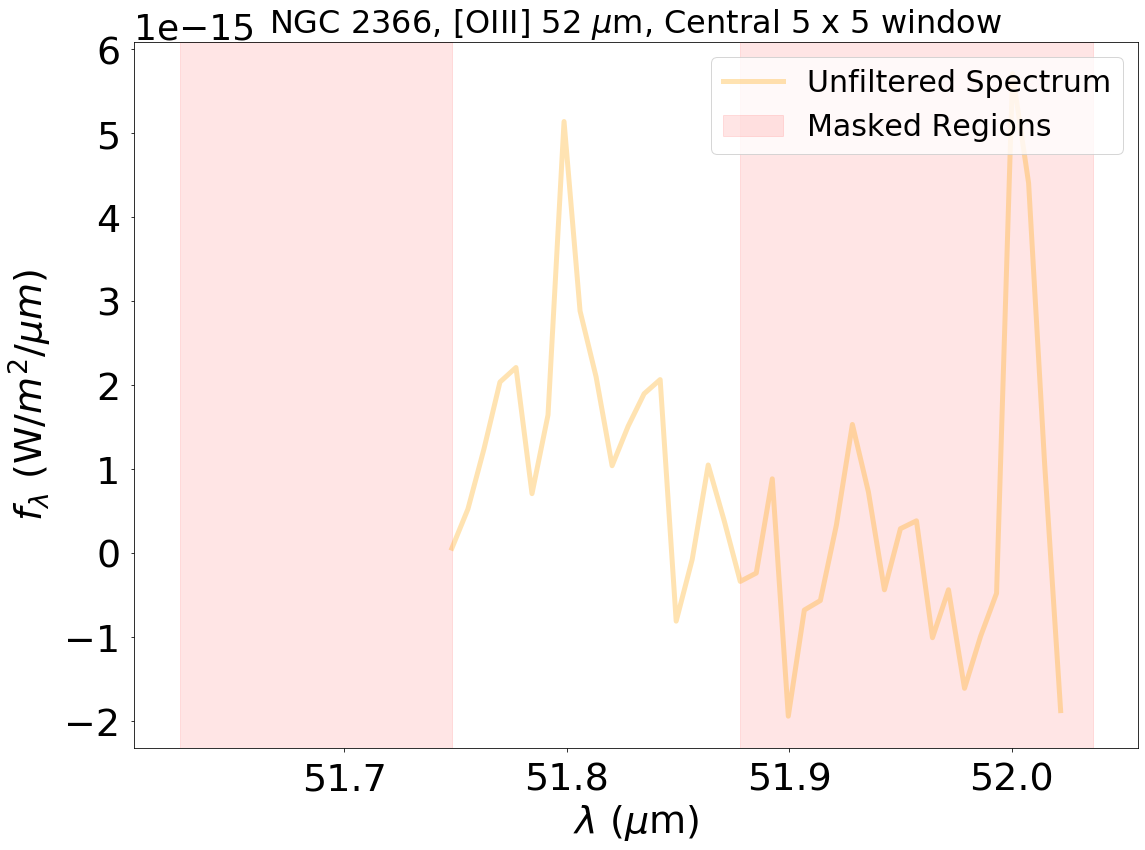

In [231]:
fig, ax = plt.subplots(figsize = (18, 13))

ax.plot(wavelengths, central_fluxes_unfiltered, label = 'Unfiltered Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax.axvspan(wavelengths[0], wavelengths[17], color = 'red', alpha = 0.1, label = 'Masked Regions')
ax.axvspan(wavelengths[35], wavelengths[-1], color = 'red', alpha = 0.1)

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(r'NGC 2366, [OIII] 52 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 32)
ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

plt.savefig(savedir + 'NGC_2366_[OIII]-1-unfiltered_spectrum.png'.format(str(n_x), str(n_y)))

ax.legend(prop={'size': 30}, loc = 'upper right')

In [188]:
print(central_fluxes_unfiltered)

[            nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan  6.14764165e-17  5.27878535e-16  1.24244403e-15
  2.03980257e-15  2.21308454e-15  7.11009837e-16  1.64899339e-15
  5.14222973e-15  2.88603630e-15  2.10274287e-15  1.04365815e-15
  1.51353998e-15  1.90096238e-15  2.06924141e-15 -8.06995797e-16
 -7.24868382e-17  1.05230919e-15  3.87154239e-16 -3.34105257e-16
 -2.34409514e-16  8.87619565e-16 -1.93863821e-15 -6.74950796e-16
 -5.61865580e-16  3.35548271e-16  1.53500229e-15  7.31846236e-16
 -4.33767585e-16  2.93694851e-16  3.87648275e-16 -1.00412246e-15
 -4.33204499e-16 -1.60672958e-15 -9.88952668e-16 -4.75384950e-16
  5.71092010e-15  4.40940217e-15  1.06826414e-15 -1.87245422e-15
             nan             nan]


In [192]:
central_fluxes_filtered = central_fluxes_unfiltered

wavelengths_filtered = wavelengths[17:36]
central_fluxes_filtered = central_fluxes_filtered[17:36]

print(central_fluxes_filtered)

[ 6.14764165e-17  5.27878535e-16  1.24244403e-15  2.03980257e-15
  2.21308454e-15  7.11009837e-16  1.64899339e-15  5.14222973e-15
  2.88603630e-15  2.10274287e-15  1.04365815e-15  1.51353998e-15
  1.90096238e-15  2.06924141e-15 -8.06995797e-16 -7.24868382e-17
  1.05230919e-15  3.87154239e-16 -3.34105257e-16]


In [216]:
central_fluxes_filtered_continuum = []

left_cut = 51.75
right_cut = 51.87

for i in range(0, len(wavelengths_filtered)):
    
    wavelength = wavelengths_filtered[i]
    
    if(wavelength < left_cut or wavelength > right_cut):
        central_fluxes_filtered_continuum.append(central_fluxes_filtered[i])
    
    else:
        central_fluxes_filtered_continuum.append(float("Nan"))
        
central_fluxes_filtered_continuum = np.array(central_fluxes_filtered_continuum)

print(central_fluxes_filtered_continuum)

[ 6.14764165e-17             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan  3.87154239e-16 -3.34105257e-16]


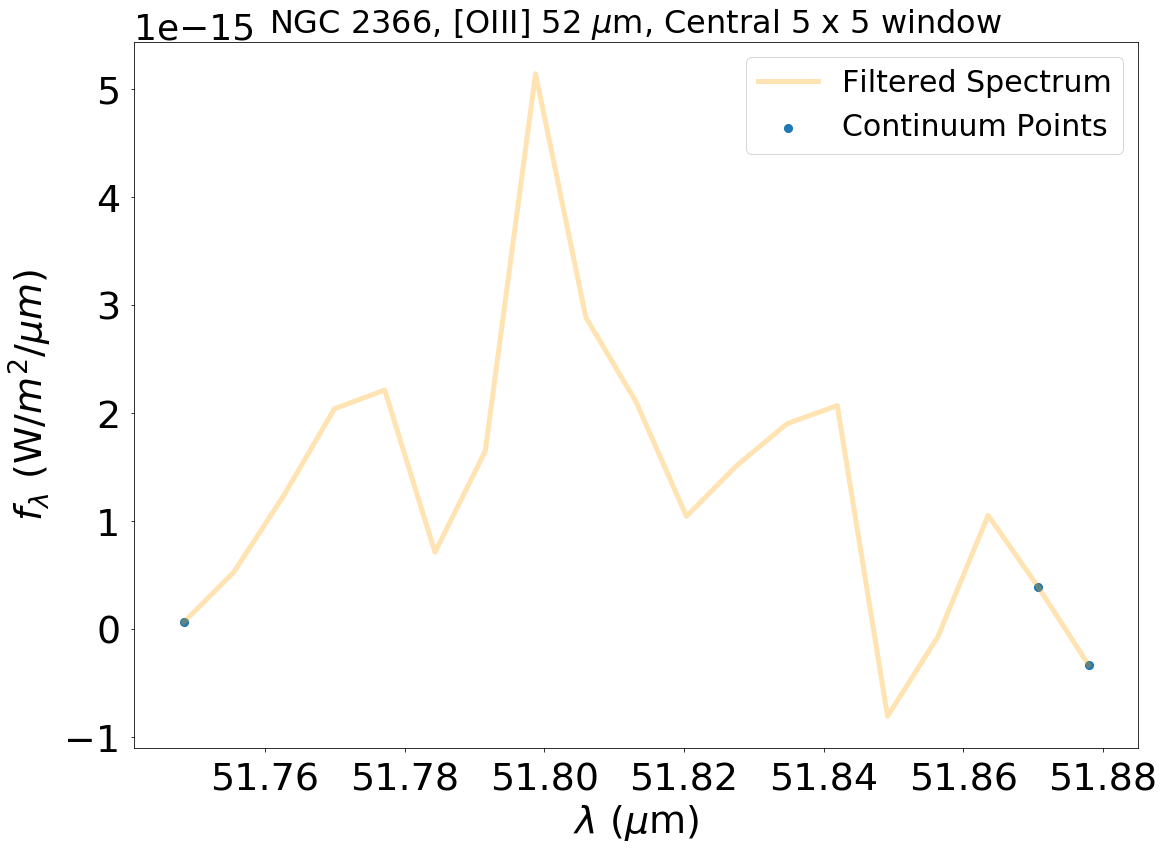

In [217]:
fig, ax = plt.subplots(figsize = (18, 13))

ax.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Filtered Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(r'NGC 2366, [OIII] 52 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 32)
ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0, 0))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 30}, loc = 'upper right')

plt.savefig(savedir + 'NGC_2366_[OIII]-2-filtered_spectrum + continuum_points.png'.format(str(n_x), str(n_y)))

In [218]:
idcont = np.isfinite(central_fluxes_filtered_continuum)
cont_params = np.polyfit(wavelengths_filtered[idcont], central_fluxes_filtered_continuum[idcont], 1)

print(cont_params)

cont_line_filtered = cont_params[0]*wavelengths_filtered + cont_params[1]

[-5.21516644e-16  2.70696092e-14]


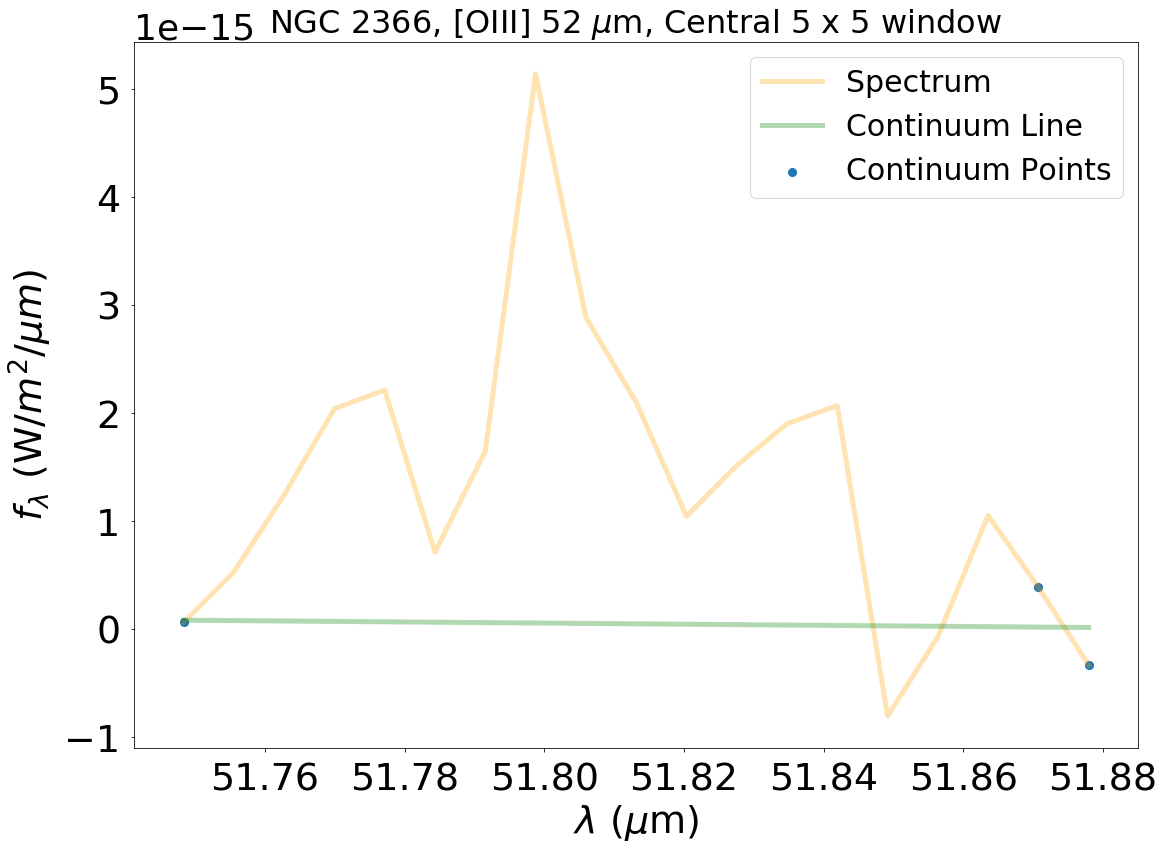

In [219]:
fig, ax = plt.subplots(figsize = (18, 13))

ax.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax.plot(wavelengths_filtered, cont_line_filtered, label = 'Continuum Line', lw = 5, color = 'green', alpha = 0.3)
ax.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(r'NGC 2366, [OIII] 52 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 32)
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 30}, loc = 'upper right')

plt.savefig(savedir + 'NGC_2366_[OIII]-3-filtered_spectrum + continuum_line.png'.format(str(n_x), str(n_y)))

In [220]:
id_act = np.isnan(central_fluxes_filtered_continuum)

wavelengths_act = wavelengths_filtered[id_act]
central_fluxes_filtered_act = central_fluxes_filtered[id_act]
cont_line_filtered_act = cont_line_filtered[id_act]

central_fluxes_continuum_subtracted_act = central_fluxes_filtered_act - cont_line_filtered_act

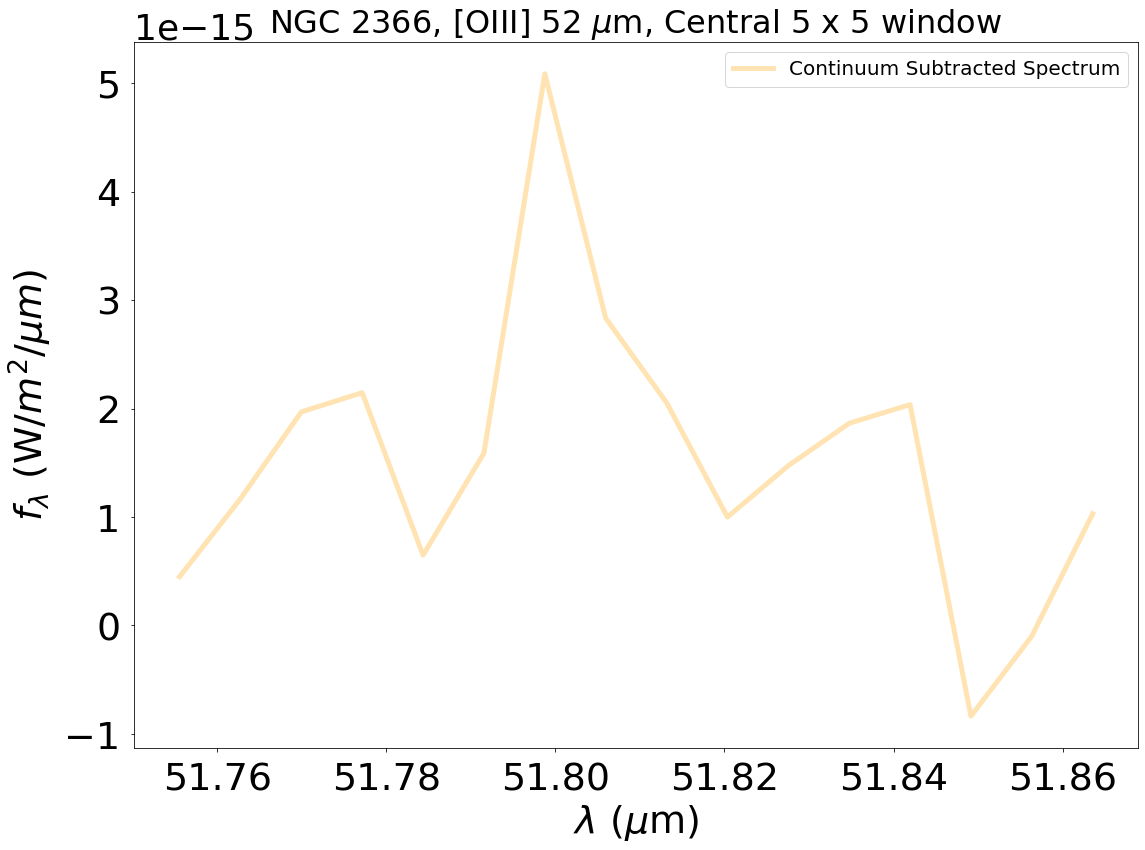

In [221]:
fig, ax = plt.subplots(figsize = (18, 13))

ax.plot(wavelengths_act, central_fluxes_continuum_subtracted_act, label = 'Continuum Subtracted Spectrum', lw = 5, color = 'orange', alpha = 0.3)

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(r'NGC 2366, [OIII] 52 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 32)
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 20}, loc = 'upper right')

plt.savefig(savedir + 'NGC_2366_[OIII]-4-continuum_subtracted_spectrum.png'.format(str(n_x), str(n_y)))

In [222]:
def fit_func_1(Z, peak_height, mu, sigma):
    
    P = peak_height*np.exp(-((Z-mu)**2/(2*sigma**2)))
    
    return P

In [226]:
heights = central_fluxes_continuum_subtracted_act/np.max(central_fluxes_continuum_subtracted_act)

centers = wavelengths_act

# Information about the peak in the numerical PDF
peak_ind = np.where(heights == np.max(heights))[0][0]
peak_height = np.max(heights)

# mu is where the numerical PDF peaks
mu = centers[peak_ind]

# Estimating sigma using FWHM
sigma = 0

for i in range(peak_ind+1, len(centers)):
    if(heights[i] < peak_height/2):
        sigma = (centers[i-1]-mu)/np.sqrt(2*np.log(2))
        break

# First fit a Gaussian

guess_params = np.array([peak_height, sigma])
fit_params, fit_covar = optimize.curve_fit(lambda centers, peak_height, sigma: 
                                           fit_func_1(centers, peak_height, mu, sigma), 
                                           centers, heights, p0=guess_params)

fit_params = [fit_params[0], mu, fit_params[1]]

fit_params[0] *= np.max(central_fluxes_continuum_subtracted_act)

print(fit_params)

[2.6983651859027552e-15, 51.798756254727486, 0.026873767139831948]


[7.41518597e-16 7.86676446e-16 8.33429553e-16 8.81739498e-16
 9.31558956e-16 9.82831450e-16 1.03549116e-15 1.08946277e-15
 1.14466142e-15 1.20099264e-15 1.25835244e-15 1.31662743e-15
 1.37569497e-15 1.43542349e-15 1.49567282e-15 1.55629457e-15
 1.61713268e-15 1.67802395e-15 1.73879870e-15 1.79928147e-15
 1.85929183e-15 1.91864516e-15 1.97715362e-15 2.03462706e-15
 2.09087404e-15 2.14570282e-15 2.19892251e-15 2.25034408e-15
 2.29978153e-15 2.34705293e-15 2.39198162e-15 2.43439721e-15
 2.47413672e-15 2.51104560e-15 2.54497871e-15 2.57580130e-15
 2.60338988e-15 2.62763305e-15 2.64843227e-15 2.66570248e-15
 2.67937271e-15 2.68938659e-15 2.69570268e-15 2.69829479e-15
 2.69715218e-15 2.69227958e-15 2.68369719e-15 2.67144058e-15
 2.65556034e-15 2.63612185e-15 2.61320474e-15 2.58690240e-15
 2.55732132e-15 2.52458040e-15 2.48881011e-15 2.45015168e-15
 2.40875610e-15 2.36478322e-15 2.31840066e-15 2.26978279e-15
 2.21910963e-15 2.16656571e-15 2.11233903e-15 2.05661989e-15
 1.99959982e-15 1.941470

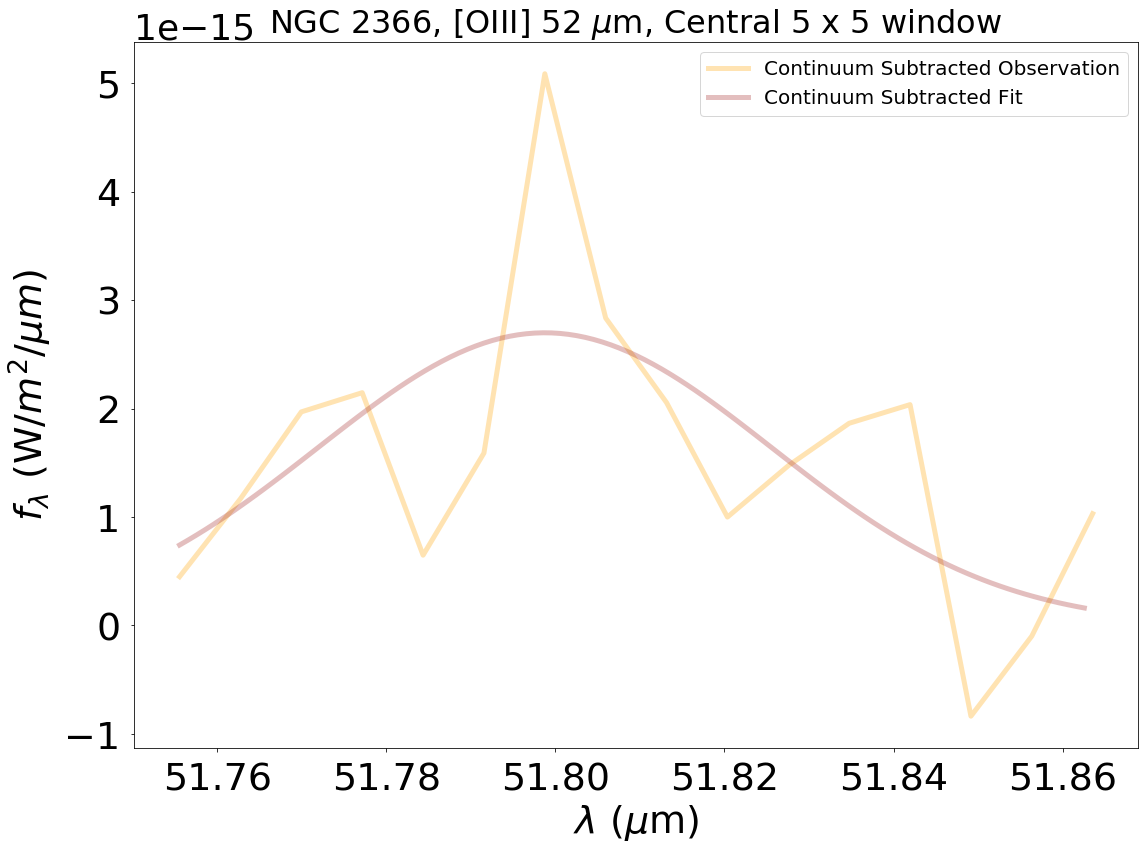

In [227]:
fig, ax = plt.subplots(figsize = (18, 13))

wavelength_range = np.arange(np.min(wavelengths_act), np.max(wavelengths_act), 0.001)

fitted_central_fluxes_continuum_subtracted_act = fit_func_1(wavelength_range, *fit_params)

print(fitted_central_fluxes_continuum_subtracted_act)

ax.plot(wavelengths_act, central_fluxes_continuum_subtracted_act, 
        label = 'Continuum Subtracted Observation', lw = 5, color = 'orange', alpha = 0.3)

ax.plot(wavelength_range, fitted_central_fluxes_continuum_subtracted_act, 
        label = 'Continuum Subtracted Fit', lw = 5, color = 'brown', alpha = 0.3)


ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(r'NGC 2366, [OIII] 52 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 32)
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 20}, loc = 'upper right')

plt.savefig(savedir + 'NGC_2366_[OIII]-5-fit_continuum_subtracted_spectrum.png'.format(str(n_x), str(n_y)))

[7.41518597e-16 7.86676446e-16 8.33429553e-16 8.81739498e-16
 9.31558956e-16 9.82831450e-16 1.03549116e-15 1.08946277e-15
 1.14466142e-15 1.20099264e-15 1.25835244e-15 1.31662743e-15
 1.37569497e-15 1.43542349e-15 1.49567282e-15 1.55629457e-15
 1.61713268e-15 1.67802395e-15 1.73879870e-15 1.79928147e-15
 1.85929183e-15 1.91864516e-15 1.97715362e-15 2.03462706e-15
 2.09087404e-15 2.14570282e-15 2.19892251e-15 2.25034408e-15
 2.29978153e-15 2.34705293e-15 2.39198162e-15 2.43439721e-15
 2.47413672e-15 2.51104560e-15 2.54497871e-15 2.57580130e-15
 2.60338988e-15 2.62763305e-15 2.64843227e-15 2.66570248e-15
 2.67937271e-15 2.68938659e-15 2.69570268e-15 2.69829479e-15
 2.69715218e-15 2.69227958e-15 2.68369719e-15 2.67144058e-15
 2.65556034e-15 2.63612185e-15 2.61320474e-15 2.58690240e-15
 2.55732132e-15 2.52458040e-15 2.48881011e-15 2.45015168e-15
 2.40875610e-15 2.36478322e-15 2.31840066e-15 2.26978279e-15
 2.21910963e-15 2.16656571e-15 2.11233903e-15 2.05661989e-15
 1.99959982e-15 1.941470

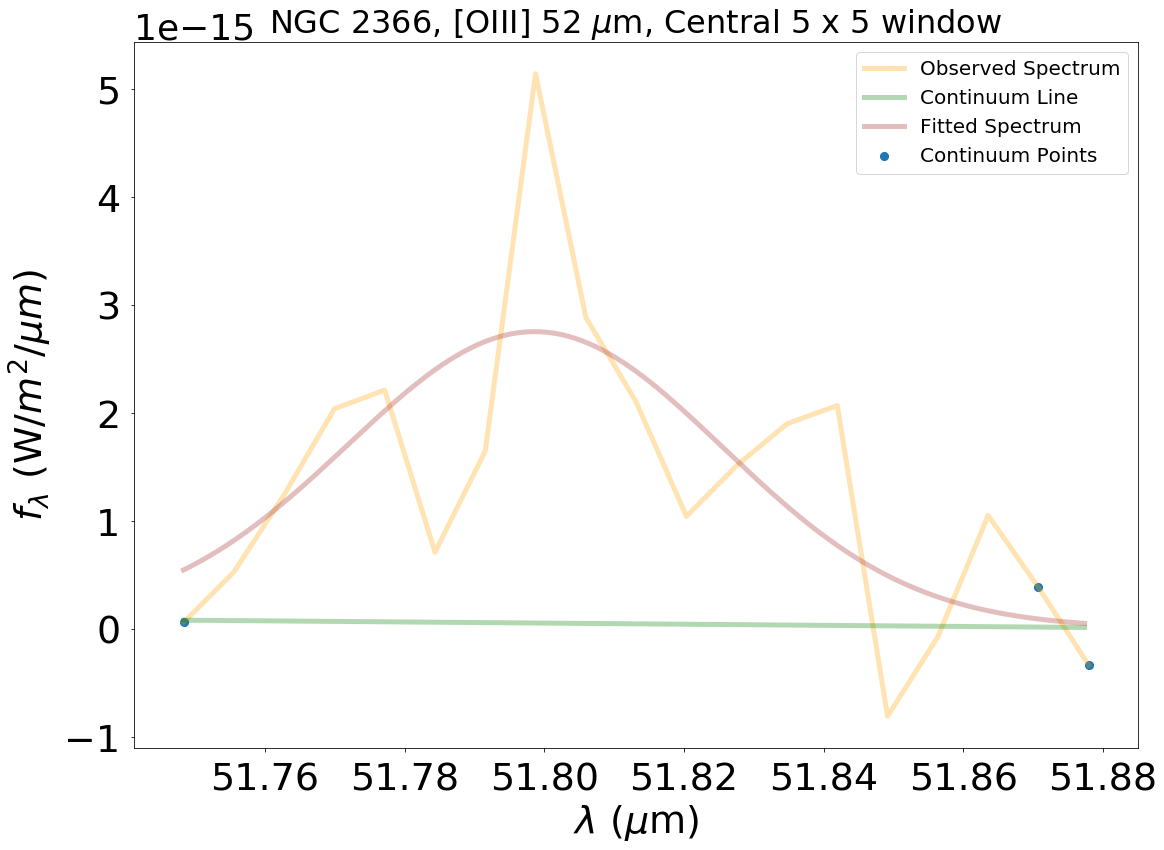

In [228]:
fig, ax = plt.subplots(figsize = (18, 13))

wavelength_range = np.arange(np.min(wavelengths_filtered), np.max(wavelengths_filtered), 0.001)
cont_line_filtered = cont_params[0]*wavelength_range + cont_params[1]

fitted_central_fluxes_act = fit_func_1(wavelength_range, *fit_params) + cont_line_filtered

print(fitted_central_fluxes_continuum_subtracted_act)

ax.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Observed Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax.plot(wavelength_range, cont_line_filtered, label = 'Continuum Line', lw = 5, color = 'green', alpha = 0.3)
ax.plot(wavelength_range, fitted_central_fluxes_act, label = 'Fitted Spectrum', lw = 5, color = 'brown', alpha = 0.3)
ax.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(r'NGC 2366, [OIII] 52 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 32)
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 20}, loc = 'upper right')

plt.savefig(savedir + 'NGC_2366_[OIII]-6-final_spectrum.png'.format(str(n_x), str(n_y)))

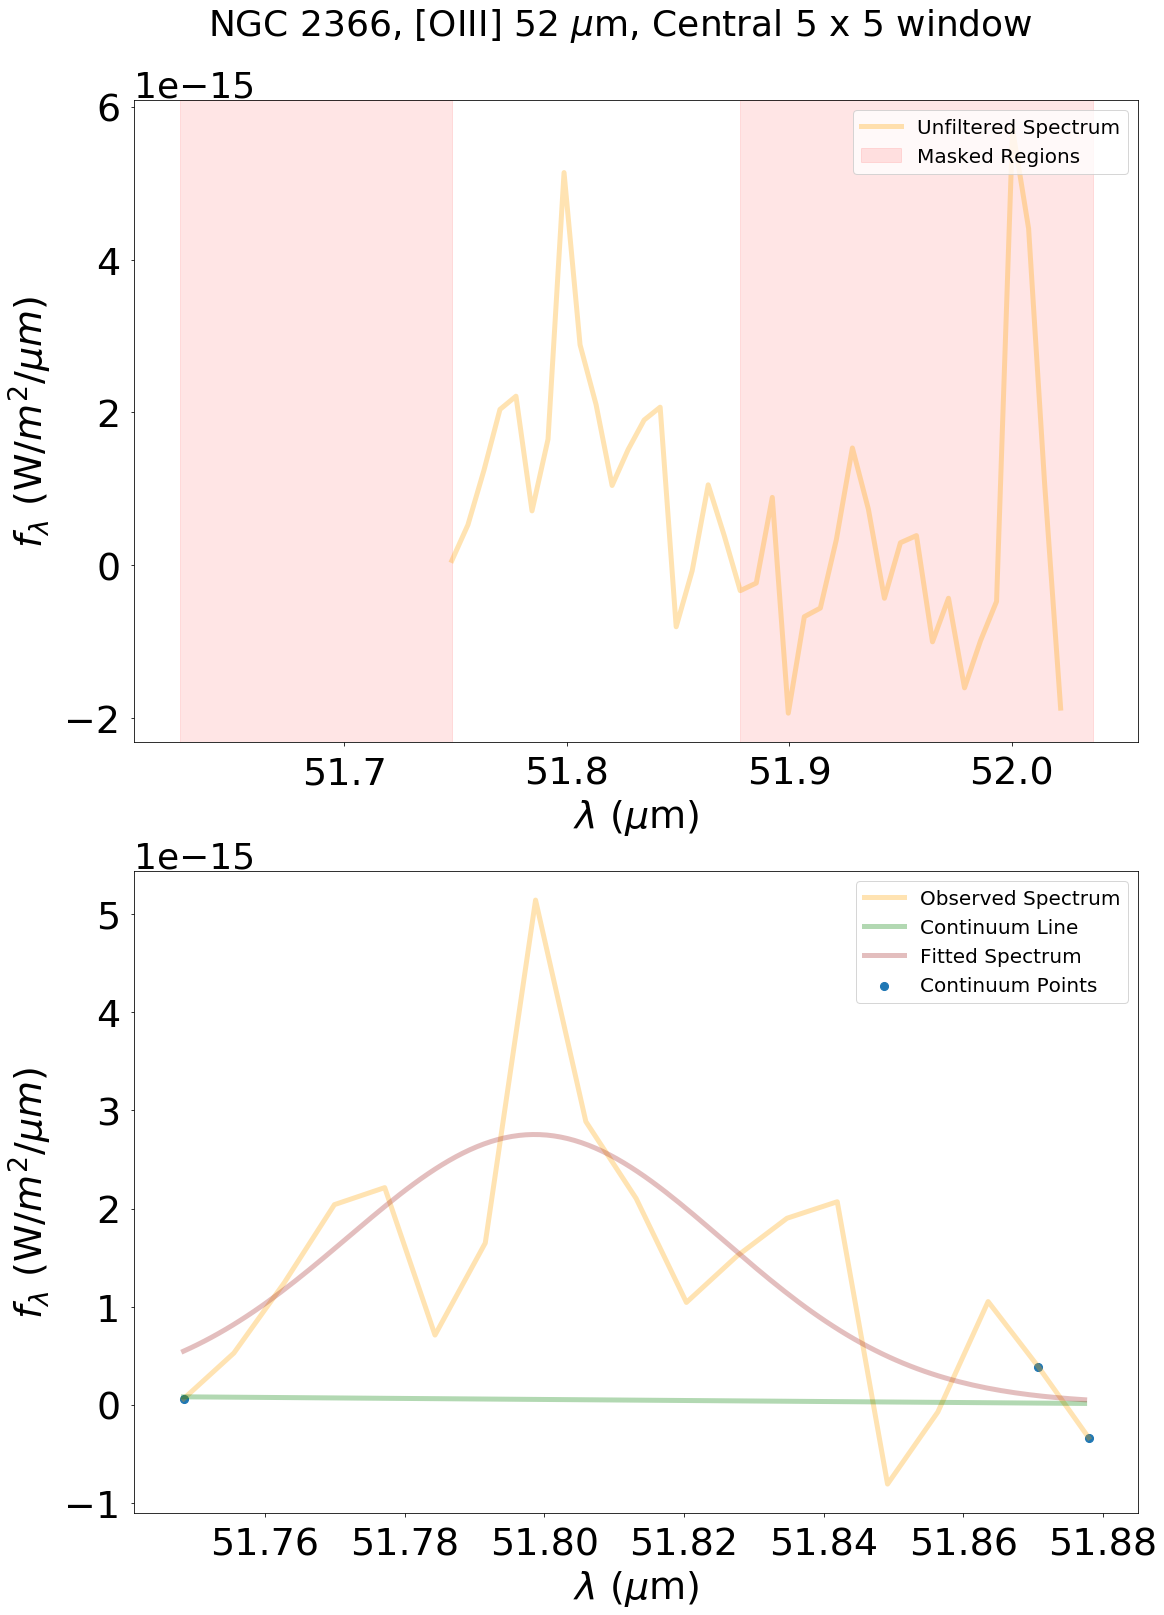

In [232]:
fig, axs = plt.subplots(2, 1, figsize = (18, 26))

ax1 = axs[0]

ax1.plot(wavelengths, central_fluxes_unfiltered, label = 'Unfiltered Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax1.axvspan(wavelengths[0], wavelengths[17], color = 'red', alpha = 0.1, label = 'Masked Regions')
ax1.axvspan(wavelengths[35], wavelengths[-1], color = 'red', alpha = 0.1)

ax1.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax1.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax1.tick_params(labelsize = 38, pad = 10)
ax1.yaxis.offsetText.set_fontsize(36)
ax1.legend(prop={'size': 20}, loc = 'upper right')

ax2 = axs[1]

ax2.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Observed Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax2.plot(wavelength_range, cont_line_filtered, label = 'Continuum Line', lw = 5, color = 'green', alpha = 0.3)
ax2.plot(wavelength_range, fitted_central_fluxes_act, label = 'Fitted Spectrum', lw = 5, color = 'brown', alpha = 0.3)
ax2.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

ax2.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax2.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax2.tick_params(labelsize = 38, pad = 10)
ax2.yaxis.offsetText.set_fontsize(36)
ax2.legend(prop={'size': 20}, loc = 'upper right')

fig.suptitle(r'NGC 2366, [OIII] 52 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 36, y = 0.93)

plt.savefig(savedir + 'NGC_2366_[OIII]-7-summary_spectrum.png'.format(str(n_x), str(n_y)))

In [233]:
flux_continuum = np.trapz(cont_line_filtered, x = wavelength_range, dx = wav_diff)

flux_obs = np.trapz(central_fluxes_filtered, x = wavelengths_filtered, dx = wav_diff)
flux_obs_sub = flux_obs - flux_continuum
print('Flux of the continuum subtracted observation = ' + str(flux_obs_sub) + ' W/m^2')

flux_fit = np.trapz(fitted_central_fluxes_act, x = wavelength_range, dx = wav_diff)
flux_fit_sub = flux_fit - flux_continuum
print('Flux of the continuum subtracted fit = ' + str(flux_fit_sub) + ' W/m^2')

print('Spectral width = ' + str(str(2*np.sqrt(np.log(2))*fit_params[2])) + r' microns')

Flux of the continuum subtracted observation = 1.7708940947114924e-16 W/m^2
Flux of the continuum subtracted fit = 1.7592981880782322e-16 W/m^2
Spectral width = 0.0447477575028906 microns
